In [1]:
#import Libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  
from utils.utils_functions import Utils_functions
from sklearn.metrics import silhouette_score

In [2]:
X, y = Utils_functions.load_data()

#faccio 4 procedimenti complementari, uno con i dati raw, uno con i dati normalizzati, uno con i dati standardizzati e uno con le componenti principali estratte tramite la pca, durante l'esplorazione del 
#dataset abbiamo notato come il 90% della varianza viene spiegato dalle prime 8 componenti.

#preprocesso i dati
datasets, datasets_names = Utils_functions.process_data(X)

In [3]:
def find_optimal_params_dbscan(X, y, eps_params, min_samples_params):
    """
    Cerca i parametri ottimali (eps e min_samples) su una griglia definita da
    eps_params e min_samples_params, massimizzando la media delle metriche.

    eps_params: lista [start_eps, end_eps, step_eps]
    min_samples_params: lista [start_ms, end_ms, step_ms]

    Ritorna (best_eps, best_min_samples, best_score).
    """
    best_eps = None
    best_min_samples = None
    best_score = -1

    # Genero i valori di eps e min_samples
    # eps_params = [start_eps, end_eps, step_eps]
    eps_values = np.arange(eps_params[0], eps_params[1] + eps_params[2], eps_params[2])
    # min_samples_params = [start_ms, end_ms, step_ms]
    ms_values = np.arange(min_samples_params[0], min_samples_params[1] + min_samples_params[2], min_samples_params[2])
    
    for eps in eps_values:
        for ms in ms_values:
            dbscan = DBSCAN(eps=eps, min_samples=ms)
            labels = dbscan.fit_predict(X)
            
            # Se DBSCAN mette tutti i punti come rumore o un singolo cluster,
            # silhouette_score fallisce. Verifichiamo:
            unique_labels = np.unique(labels)
            if len(unique_labels) < 2:
                continue
            
            ari = adjusted_rand_score(y, labels)
            nmi = normalized_mutual_info_score(y, labels)
            hom = homogeneity_score(y, labels)
            comp = completeness_score(y, labels)
            vms = v_measure_score(y, labels)

            #faccio la media delle metriche
            score = (ari + nmi + hom + comp + vms) / 5
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = ms
    
    return best_eps, best_min_samples, best_score

In [4]:
#rispettivamente per ciascun dataset indicano:
#start eps, end eps, step eps
dbscan_eps_params = [
    [50, 500, 50],    # Dataset 1 
    [0.1, 2.0, 0.1],     # Dataset 2
    [0.05, 1.0, 0.05],    # Dataset 3
    [0.1, 2.0, 0.1]     # Dataset 4
]

#rispettivamente per ciascun dataset indicano:
#start min sample, end min sample, step min sample
dbscan_min_sample_params = [
    [5, 50, 5],    # Dataset 1 
    [3, 30, 3],     # Dataset 2
    [3, 30, 3],    # Dataset 3
    [3, 30, 3]     # Dataset 4
]



Best Parameters with Dataset: Raw
Best eps: 50
Best min_samples: 30
Best Score: 0.2679


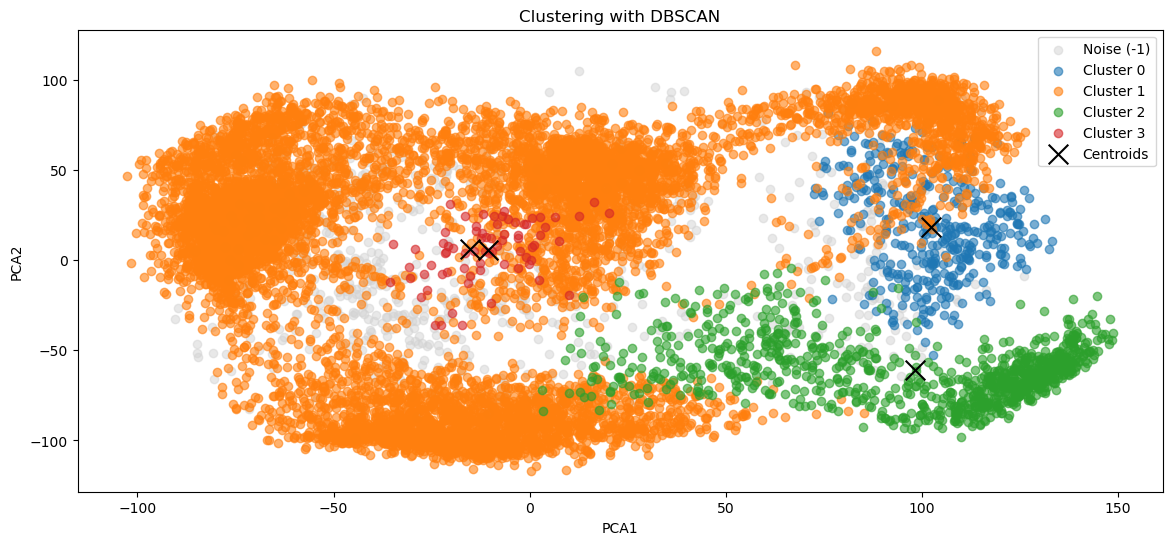

Metriche con Dataset: Raw
ARI: 0.0508
NMI: 0.2693
Homogeneity: 0.1759
Completeness: 0.5743
V-Measure: 0.2693
SSE: 127988676.1392


Best Parameters with Dataset: Standardized
Best eps: 1.2000000000000002
Best min_samples: 27
Best Score: 0.7101


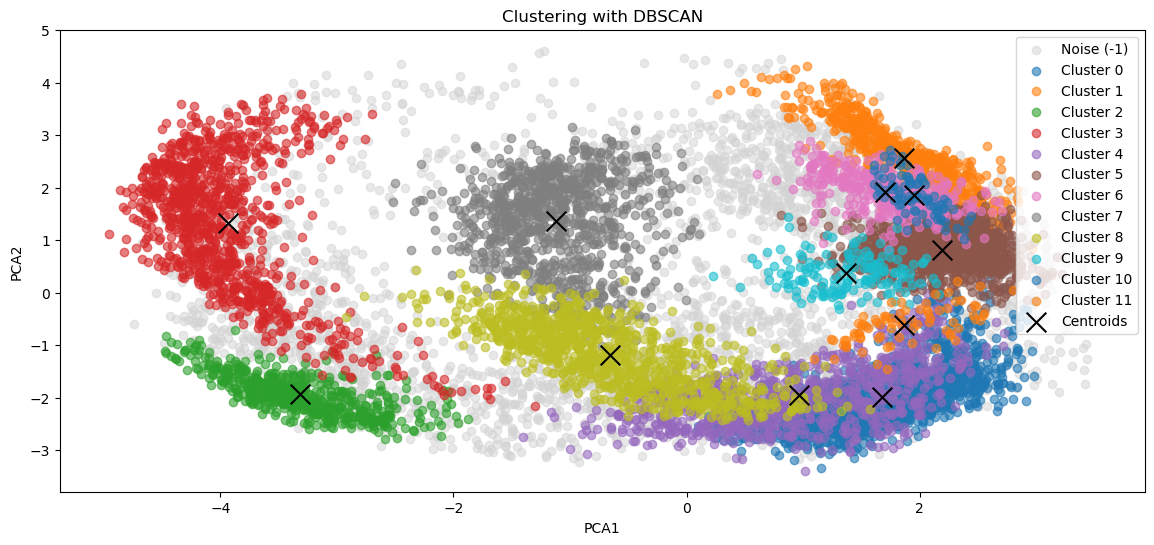

Metriche con Dataset: Standardized
ARI: 0.5520
NMI: 0.7496
Homogeneity: 0.7392
Completeness: 0.7603
V-Measure: 0.7496
SSE: 28533.1738


Best Parameters with Dataset: Normalized
Best eps: 0.30000000000000004
Best min_samples: 6
Best Score: 0.6878


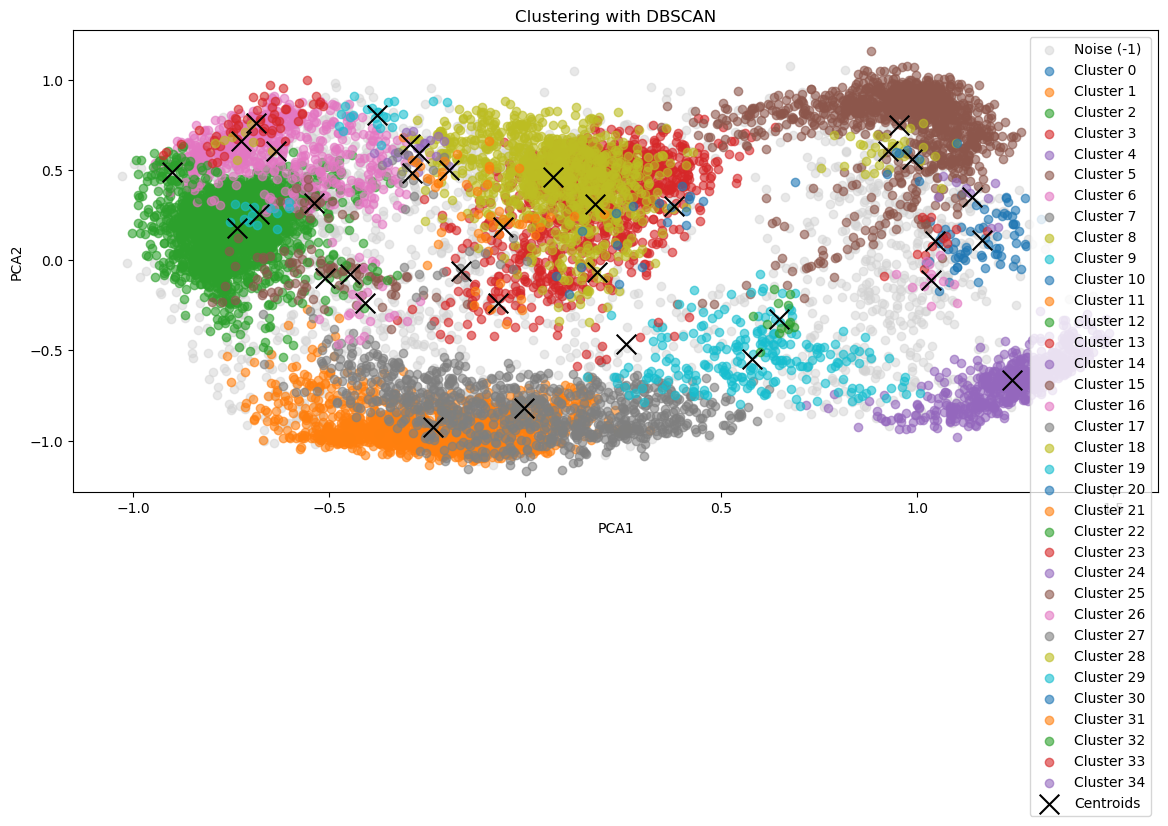

Metriche con Dataset: Normalized
ARI: 0.5648
NMI: 0.7183
Homogeneity: 0.7372
Completeness: 0.7004
V-Measure: 0.7183
SSE: 3400.4258


Best Parameters with Dataset: Extracted
Best eps: 1.0
Best min_samples: 27
Best Score: 0.6476


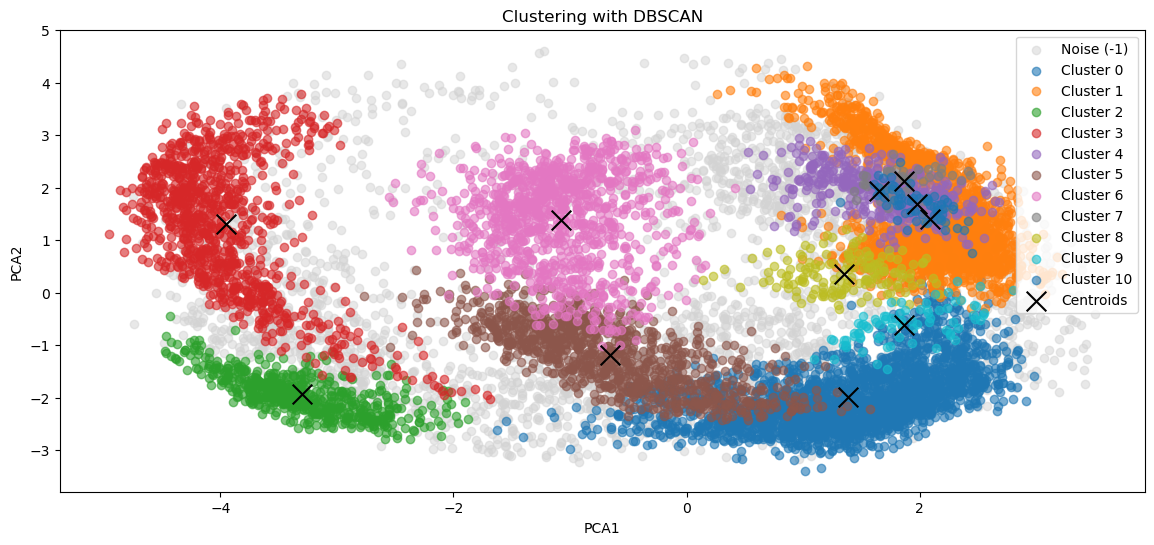

Metriche con Dataset: Extracted
ARI: 0.4911
NMI: 0.6855
Homogeneity: 0.6468
Completeness: 0.7290
V-Measure: 0.6855
SSE: 32518.6826




In [6]:


# Esempio: datasets potrebbe essere una lista di array NumPy o DataFrame
#          datasets_names una lista di stringhe corrispondenti ai nomi dei dataset
for i, X in enumerate(datasets):
    
    best_eps, best_min_samples, best_score = find_optimal_params_dbscan(
        X,
        y,
        eps_params=dbscan_eps_params[i],
        min_samples_params=dbscan_min_sample_params[i]
    )

    print(f"Best Parameters with Dataset: {datasets_names[i]}")
    print(f"Best eps: {best_eps}")
    print(f"Best min_samples: {best_min_samples}")
    print(f"Best Score: {best_score:.4f}")
    
    # Inizializzazione del modello DBSCAN
    # - eps: distanza massima tra due campioni per essere considerati nello stesso cluster
    # - min_samples: numero minimo di campioni in un vicinato per essere considerato core point
    dbscan = DBSCAN(eps = best_eps, min_samples = best_min_samples)
    
    # Eseguo il clustering con DBSCAN
    labels = dbscan.fit_predict(X)

    # Riduco le dimensioni per poter fare il plot in 2D tranne per il dataset in cui è già stato fatta la PCA
    if i < 3:
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(X)

    # Calcolo i centroidi come media dei punti per ogni cluster
    # DBSCAN assegna -1 ai punti considerati rumore (outliers).
    # Quindi, evito di calcolare il "centroide" per la classe -1.
    unique_labels = np.unique(labels)
    valid_labels = unique_labels[unique_labels != -1]  # escludo il cluster -1
    
    # Calcolo dei centroidi solo per i cluster validi (non rumore)
    centroids = []
    for cluster_id in valid_labels:
        cluster_points = reduced_data[labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)

    # Creo un DataFrame con i dati ridotti e i cluster
    df_pca = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
    df_pca['Cluster'] = labels

    # Plotto i dati in 2D, distinguendo il cluster -1 (rumore) dagli altri
    plt.figure(figsize=(14, 6))
    
    # Colori per i cluster
    # Se ci sono cluster -1 e altri cluster, li gestisco separatamente
    noise_data = df_pca[df_pca['Cluster'] == -1]
    if not noise_data.empty:
        plt.scatter(noise_data['PCA1'], noise_data['PCA2'],
                    label='Noise (-1)',
                    alpha=0.5,
                    c='lightgray')

    # Per ogni cluster valido, plotto i punti
    for cluster_id in valid_labels:
        cluster_data = df_pca[df_pca['Cluster'] == cluster_id]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'],
                    label=f'Cluster {cluster_id}',
                    alpha=0.6)
    
    # Plotto i centroidi calcolati
    if len(centroids) > 0:
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x',
                    s=200,
                    c='black',
                    label='Centroids')
    
    plt.title('Clustering with DBSCAN')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

    # Calcolo le metriche di similarità (supervisionate) rispetto alle etichette vere y
    # Attenzione: DBSCAN potrebbe etichettare molti punti come -1 (rumore),
    # quindi ARI, NMI, etc. possono risultare bassi se il dataset è rumoroso.
    ari = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels)
    hom = homogeneity_score(y, labels)
    comp = completeness_score(y, labels)
    vms = v_measure_score(y, labels)
    sse = Utils_functions.compute_SSE(X, labels)

    print(f"Metriche con Dataset: {datasets_names[i]}")
    print(f"ARI: {ari:.4f}")
    print(f"NMI: {nmi:.4f}")
    print(f"Homogeneity: {hom:.4f}")
    print(f"Completeness: {comp:.4f}")
    print(f"V-Measure: {vms:.4f}")
    print(f"SSE: {sse:.4f}")
    print("\n")

Best Parameters with Dataset: Raw
Best eps: 50
Best min_samples: 30
Best Score: 0.2679


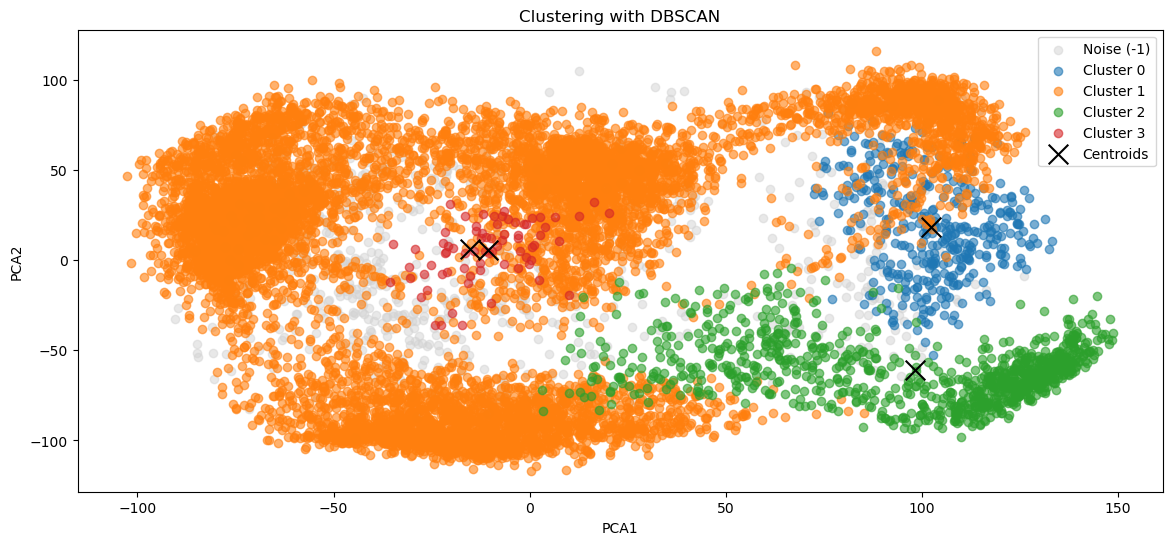

Metriche con Dataset: Raw
ARI: 0.0508
NMI: 0.2693
Homogeneity: 0.1759
Completeness: 0.5743
V-Measure: 0.2693
SSE: 127988676.1392


Elbow Method Analysis for Dataset: Raw


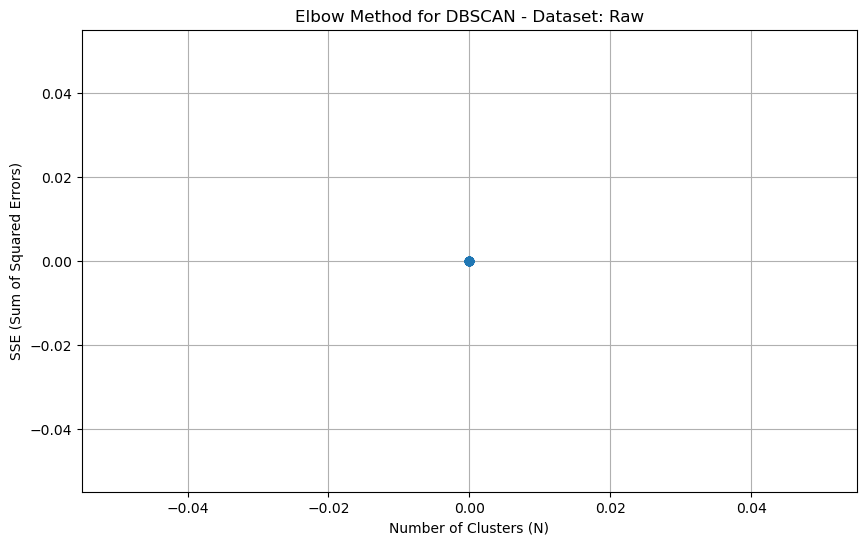

Il numero reale dei cluster (10) non è stato rilevato nel range analizzato.
Best Parameters with Dataset: Standardized
Best eps: 1.2000000000000002
Best min_samples: 27
Best Score: 0.7101


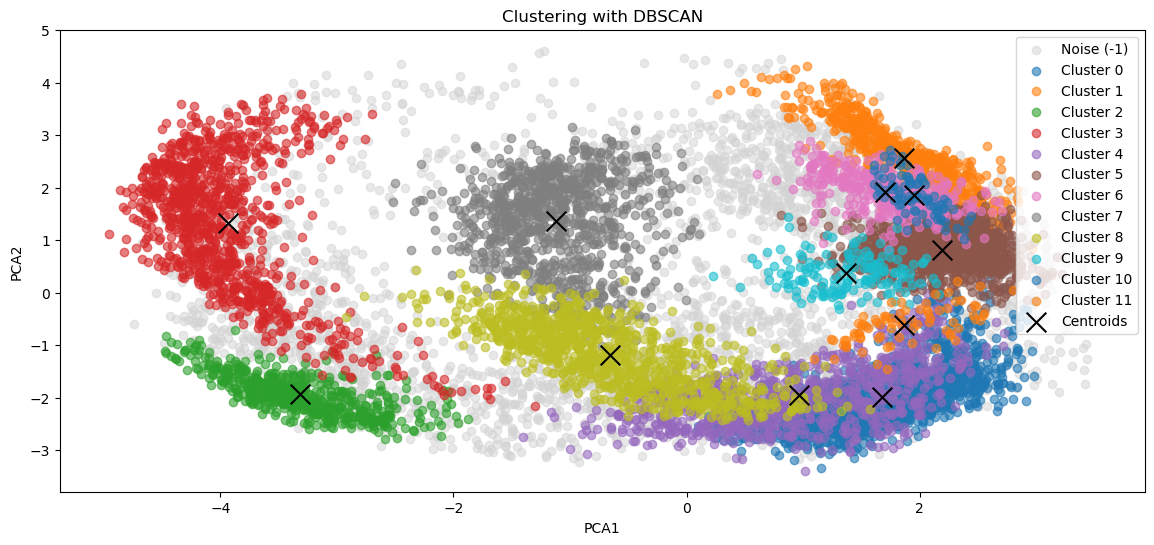

Metriche con Dataset: Standardized
ARI: 0.5520
NMI: 0.7496
Homogeneity: 0.7392
Completeness: 0.7603
V-Measure: 0.7496
SSE: 28533.1738


Elbow Method Analysis for Dataset: Standardized


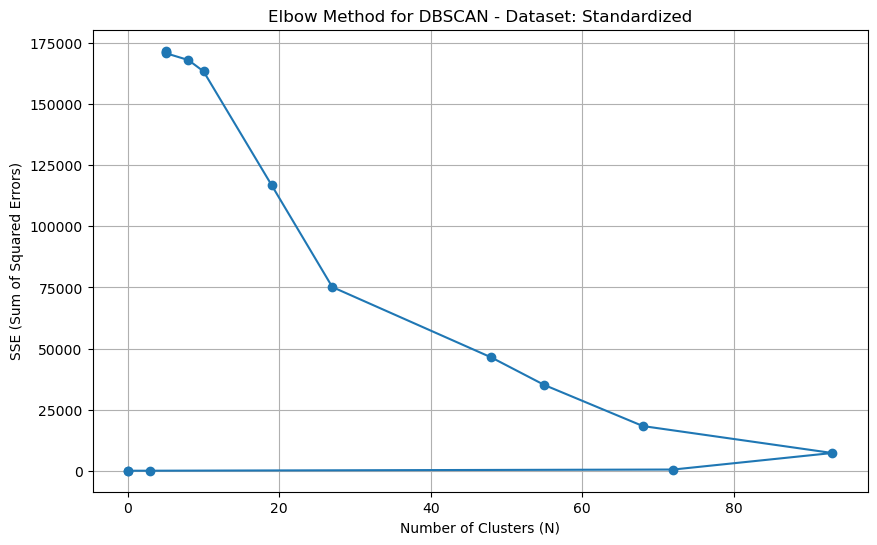

Il numero reale dei cluster (10) è stato rilevato con SSE: 163423.6144
Best Parameters with Dataset: Normalized
Best eps: 0.30000000000000004
Best min_samples: 6
Best Score: 0.6878


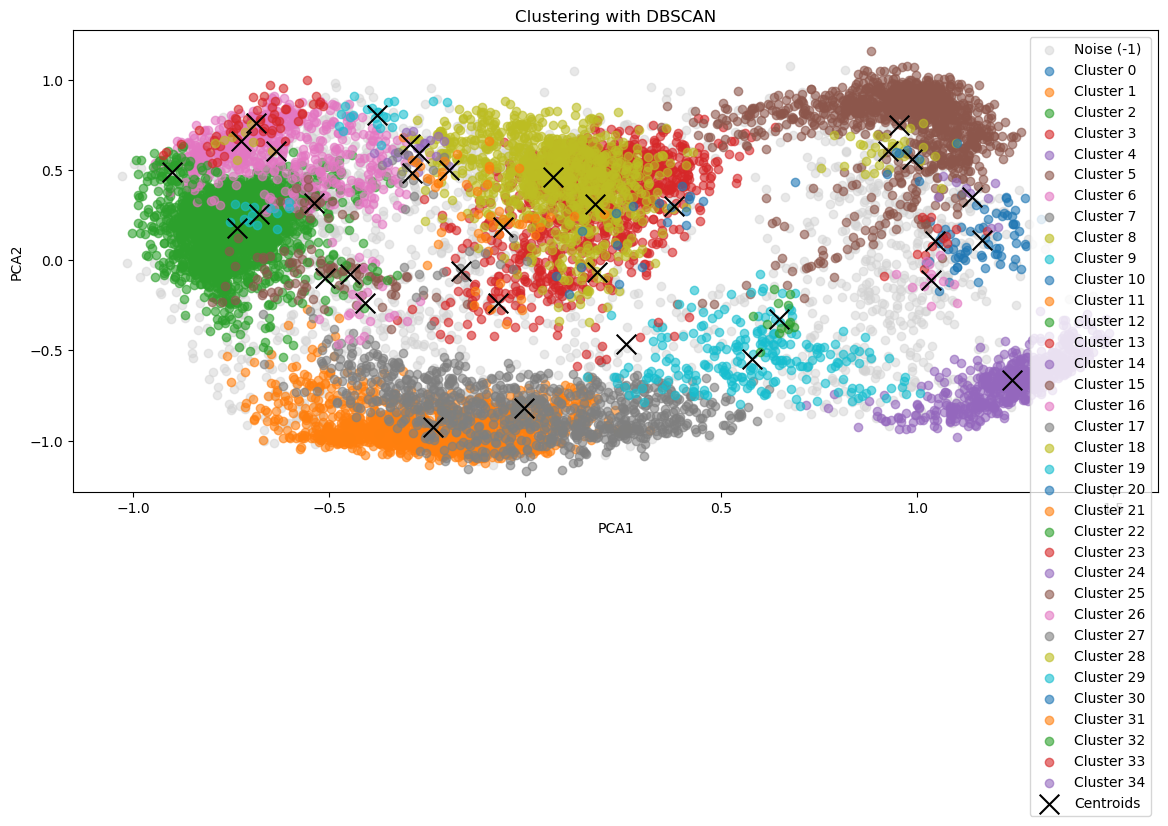

Metriche con Dataset: Normalized
ARI: 0.5648
NMI: 0.7183
Homogeneity: 0.7372
Completeness: 0.7004
V-Measure: 0.7183
SSE: 3400.4258


Elbow Method Analysis for Dataset: Normalized


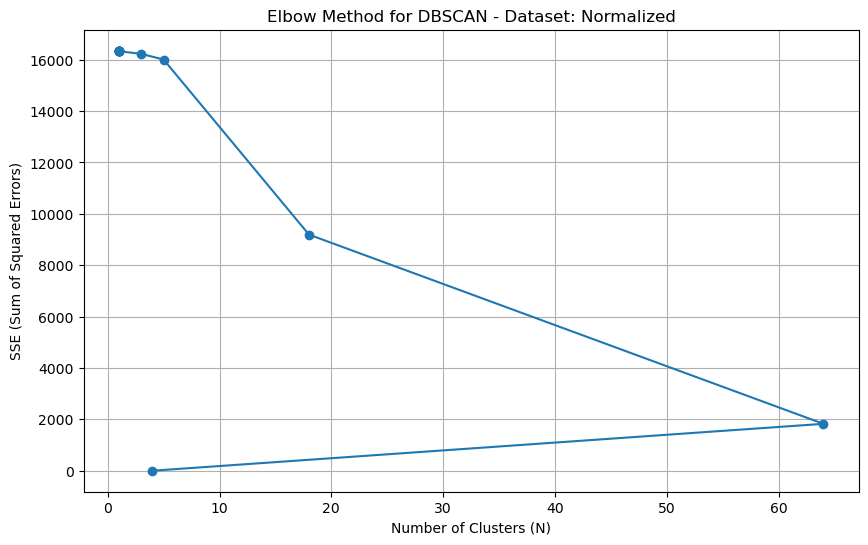

Il numero reale dei cluster (10) non è stato rilevato nel range analizzato.
Best Parameters with Dataset: Extracted
Best eps: 1.0
Best min_samples: 27
Best Score: 0.6476


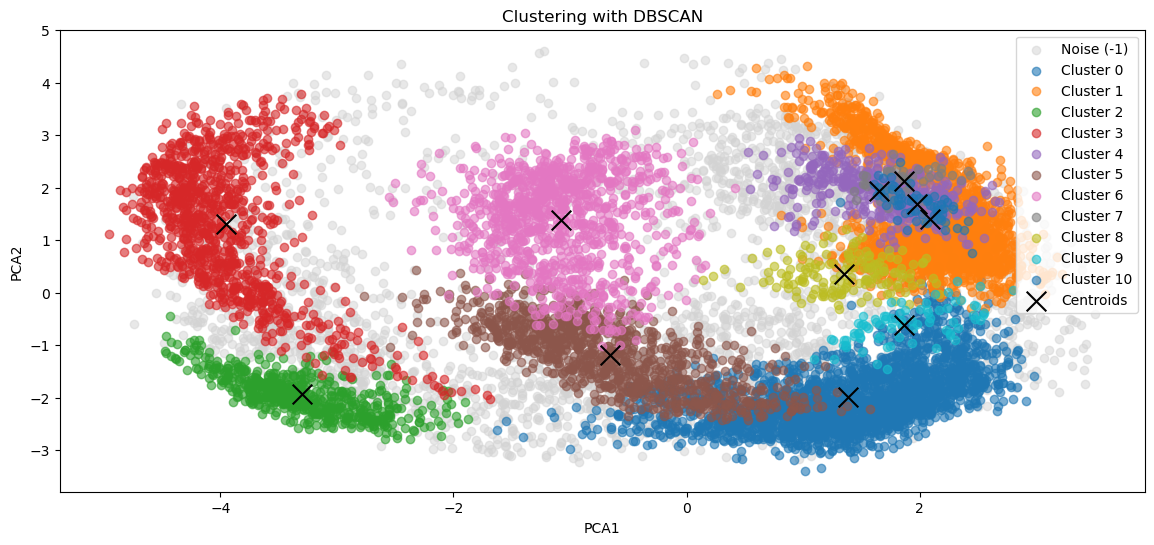

Metriche con Dataset: Extracted
ARI: 0.4911
NMI: 0.6855
Homogeneity: 0.6468
Completeness: 0.7290
V-Measure: 0.6855
SSE: 32518.6826


Elbow Method Analysis for Dataset: Extracted


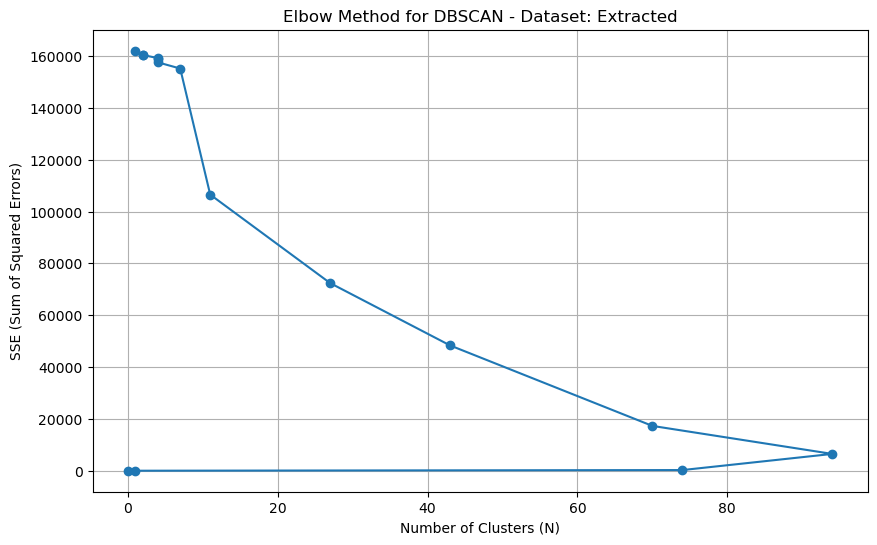

Il numero reale dei cluster (10) non è stato rilevato nel range analizzato.


In [9]:
# Ciclo principale per i dataset
def run_dbscan_analysis(datasets, datasets_names, dbscan_eps_params, dbscan_min_sample_params):
    for i, X in enumerate(datasets):

        best_eps, best_min_samples, best_score = find_optimal_params_dbscan(
            X,
            y,
            eps_params=dbscan_eps_params[i],
            min_samples_params=dbscan_min_sample_params[i]
        )

        print(f"Best Parameters with Dataset: {datasets_names[i]}")
        print(f"Best eps: {best_eps}")
        print(f"Best min_samples: {best_min_samples}")
        print(f"Best Score: {best_score:.4f}")

        # Inizializzazione del modello DBSCAN
        dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
        labels = dbscan.fit_predict(X)

        # Riduco le dimensioni per il plot in 2D
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(X)

        # Calcolo i centroidi solo per i cluster validi (non rumore)
        unique_labels = np.unique(labels)
        valid_labels = unique_labels[unique_labels != -1]  # escludo il cluster -1
        centroids = []
        for cluster_id in valid_labels:
            cluster_points = reduced_data[labels == cluster_id]
            centroid = cluster_points.mean(axis=0)
            centroids.append(centroid)
        centroids = np.array(centroids)

        # Creo un DataFrame con i dati ridotti e i cluster
        df_pca = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
        df_pca['Cluster'] = labels

        # Plotto i dati in 2D, distinguendo il cluster -1 (rumore) dagli altri
        plt.figure(figsize=(14, 6))
        
        noise_data = df_pca[df_pca['Cluster'] == -1]
        if not noise_data.empty:
            plt.scatter(noise_data['PCA1'], noise_data['PCA2'],
                        label='Noise (-1)',
                        alpha=0.5,
                        c='lightgray')

        for cluster_id in valid_labels:
            cluster_data = df_pca[df_pca['Cluster'] == cluster_id]
            plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'],
                        label=f'Cluster {cluster_id}',
                        alpha=0.6)
        
        if len(centroids) > 0:
            plt.scatter(centroids[:, 0], centroids[:, 1],
                        marker='x',
                        s=200,
                        c='black',
                        label='Centroids')
        
        plt.title('Clustering with DBSCAN')
        plt.xlabel('PCA1')
        plt.ylabel('PCA2')
        plt.legend()
        plt.show()

        # Calcolo delle metriche di similarità (supervisionate) rispetto alle etichette vere y
        ari = adjusted_rand_score(y, labels)
        nmi = normalized_mutual_info_score(y, labels)
        hom = homogeneity_score(y, labels)
        comp = completeness_score(y, labels)
        vms = v_measure_score(y, labels)
        sse = Utils_functions.compute_SSE(X, labels)

        print(f"Metriche con Dataset: {datasets_names[i]}")
        print(f"ARI: {ari:.4f}")
        print(f"NMI: {nmi:.4f}")
        print(f"Homogeneity: {hom:.4f}")
        print(f"Completeness: {comp:.4f}")
        print(f"V-Measure: {vms:.4f}")
        print(f"SSE: {sse:.4f}")
        print("\n")

        # Elbow Method per epsilon
        print(f"Elbow Method Analysis for Dataset: {datasets_names[i]}")
        cluster_counts = []
        sse_values = []
        eps_values = np.linspace(0.1, 2.0, 15)  # Variazione di epsilon

        for eps in eps_values:
            dbscan = DBSCAN(eps=eps, min_samples=5)
            labels = dbscan.fit_predict(X)
            num_clusters = len(set(labels[labels != -1]))  # Conta i cluster validi
            cluster_counts.append(num_clusters)
            sse = Utils_functions.compute_SSE(X, labels)
            sse_values.append(sse)

        # Traccia il grafico SSE
        plt.figure(figsize=(10, 6))
        plt.plot(cluster_counts, sse_values, marker='o')
        plt.title(f'Elbow Method for DBSCAN - Dataset: {datasets_names[i]}')
        plt.xlabel('Number of Clusters (N)')
        plt.ylabel('SSE (Sum of Squared Errors)')
        plt.grid()
        plt.show()

        # Verifica se il numero reale di cluster corrisponde a quello ottimale
        if 10 in cluster_counts:
            print(f"Il numero reale dei cluster (10) è stato rilevato con SSE: {sse_values[cluster_counts.index(10)]:.4f}")
        else:
            print("Il numero reale dei cluster (10) non è stato rilevato nel range analizzato.")

# Esegui il ciclo per analizzare i dataset
run_dbscan_analysis(datasets, datasets_names, dbscan_eps_params, dbscan_min_sample_params)

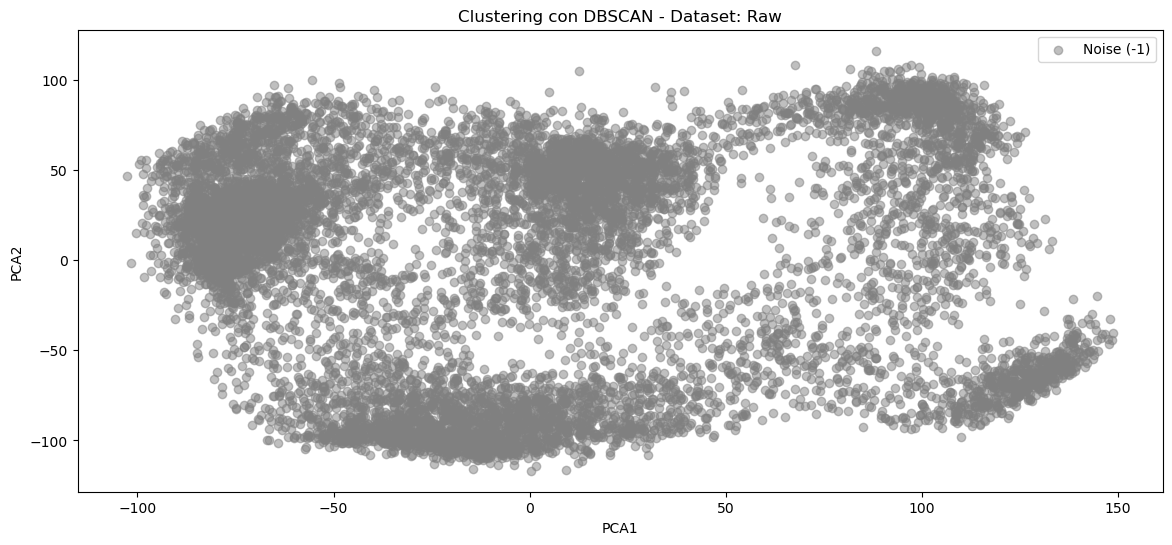

Nessun k in [2..15] è stato trovato per Raw. Impossibile tracciare SSE.


NameError: name 'compute_sse' is not defined

In [46]:
# colonne per PCA
columns = [f"PCA{i}" for i in range(1, 9)]
columns_2d = [f"PCA{i}" for i in range(1, 3)]
columns_3d = columns_2d = [f"PCA{i}" for i in range(1, 4)]



#funzione per trovare il "gomito" del grafico SSE vs numero di cluster
def find_elbow_point(x_vals, y_vals):
    """
    Trova il punto del "elbow" utilizzando il metodo della distanza massima.

    Parameters:
    x_vals (list): Valori x (numero di cluster)
    y_vals (list): Valori y (SSE medio)

    Returns:
    int: Numero di cluster corrispondente al gomito
    """
    p1 = np.array([x_vals[0], y_vals[0]])
    p2 = np.array([x_vals[-1], y_vals[-1]])

    max_distance = -1
    elbow_point = x_vals[0]

    #Calcola la distanza massima dalla linea retta tra il primo e l'ultimo punto
    for i in range(len(x_vals)):
        p = np.array([x_vals[i], y_vals[i]])
        distance = np.abs(np.cross(p2-p1, p-p1) / np.linalg.norm(p2-p1))
        if distance > max_distance:
            max_distance = distance
            elbow_point = x_vals[i]

    return elbow_point

param_grid = {
    'eps': np.arange(0.1, 3, 0.5),      
    'min_samples': range(6, 30, 5),
}

for i, X in enumerate(datasets):
    X = np.array(X, dtype=float)  
    y = np.array(y, dtype=int)  

    #dizionario per tenere traccia dell'sse in base ai cluster
    sse_dict = {k: [] for k in range(2, 16)}

    best_score = -1.0
    best_params = (None, None)  #(eps, min_samples)

    #grid search
    for eps in param_grid['eps']:
        for min_s in param_grid['min_samples']:
            dbscan_test = DBSCAN(eps=eps, min_samples=min_s)
            labels_test = dbscan_test.fit_predict(X)

            #calcolo ARI
            ari_test = adjusted_rand_score(y, labels_test)

            #aggiorno i migliori parametri se trovo uno score ARI più alto
            if ari_test > best_score:
                best_score = ari_test
                best_params = (eps, min_s)

            #calcolo numero di cluster (ignorando -1 se presente)
            unique_labels = set(labels_test)
            if -1 in unique_labels:
                unique_labels.remove(-1)
            k = len(unique_labels)

            #se k in [2..15], calcolo l’SSE e lo salvo
            if 2 <= k <= 15:
                sse_value = compute_sse(X, labels_test)
                sse_dict[k].append((sse_value, eps, min_s))  #salvo anche i parametri

    #terminata la grid search, uso i parametri "migliori" per un clustering finale
    best_eps, best_min_samples = best_params
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    labels = dbscan.fit_predict(X)

    #riduzione con pca per il plot
    if i != 3: 
        pca = PCA(n_components=8)
        reduced_data = pca.fit_transform(X)
    else:
        reduced_data = X

    #calcolo i centroidi reali dei cluster (senza -1)
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    centroids = []
    for cluster_id in unique_labels:
        cluster_points = reduced_data[labels == cluster_id]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)

    #plot dei risultati 
    df_pca = pd.DataFrame(reduced_data, columns=columns)
    df_pca['Cluster'] = labels

    plt.figure(figsize=(14, 6))
    for cluster_id in set(labels):
        cluster_data = df_pca[df_pca['Cluster'] == cluster_id]
        if cluster_id == -1:
            plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                        label='Noise (-1)', alpha=0.5, c='gray')
        else:
            plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                        label=f'Cluster {cluster_id}', alpha=0.6)

    #plot dei centroidi
    if len(centroids) > 0:
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=200, c='black', 
                    label='Centroids')

    plt.title(f"Clustering con DBSCAN - Dataset: {datasets_names[i]}")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.show()

    #grafico sse vs numero di cluster
    x_vals, y_vals = [], []
    for k in range(2, 16):
        if len(sse_dict[k]) > 0:
            avg_sse = np.mean([entry[0] for entry in sse_dict[k]])  #solo valori SSE
            x_vals.append(k)
            y_vals.append(avg_sse)

    if len(x_vals) > 0:  #evito errori se non c'è nessun k in [2..15]
        elbow_point = find_elbow_point(x_vals, y_vals)

        plt.figure(figsize=(8, 5))
        plt.plot(x_vals, y_vals, marker='o', label='SSE medio')
        plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
        plt.xlabel("Numero di cluster")
        plt.ylabel("SSE medio")
        plt.title(f"SSE medio vs # cluster (DBSCAN) - {datasets_names[i]}")
        plt.grid(True)
        plt.legend()
        plt.show()

        print(f"Il punto del gomito si trova a {elbow_point} cluster per {datasets_names[i]}.")
    else:
        print(f"Nessun k in [2..15] è stato trovato per {datasets_names[i]}. Impossibile tracciare SSE.")
